<a href="https://colab.research.google.com/github/ksenz2001/ksenz2001/blob/main/DBS_settings_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**RECOMMENDER SYSTEM FOR THE NEUROSTIMULATION SETTING ADJUSTMENT**



---

**Disclaimer.** The author of the project is not affiliated with any medical equipment manufacturers, health care providers, medical professionals or other institutions. The project does not use personal data. The technical and biomedical data are greatly simplified, and cannot be used without proper revision.

---

Neurostimulation is the purposeful modulation of the nervous system's activity using invasive (e.g. microelectrodes) or non-invasive means. Neurostimulation usually refers to the electromagnetic approaches to neuromodulation.

Deep brain stimulation (DBS) has shown benefits for movement disorders such as Parkinson's disease, tremor and dystonia and affective disorders such as depression, obsessive-compulsive disorder, Tourette syndrome, chronic pain and cluster headache. DBS can directly change the brain activity in a controlled manner and is hence used to map fundamental mechanisms of brain functions along with neuroimaging methods.

The technique of DBS involves the implantation of electrodes in the basal ganglia of the brain and the constant supply of electrical current for external regulation of neuronal activity. A DBS system consists of three components: the implanted pulse generator (IPG), the lead, and an extension. The implantable pulse generator (PG) generates stimulation pulses, which are sent to intracranial leads at the target via an extension. The simulation pulses interfere with neural activity at the target site.


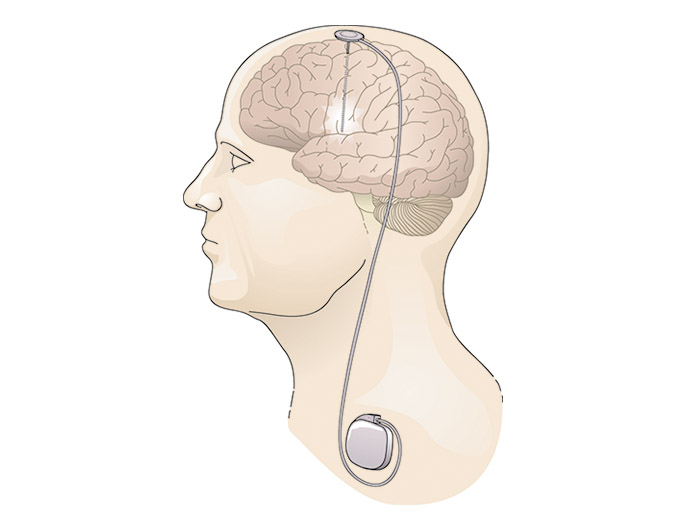

The application and effects of DBS, on both normal and diseased brains, involves many parameters. These include the physiological properties of the brain tissue, which may change with disease state. Also important are the stimulation parameters, such as amplitude and temporal characteristics, and the geometric configuration of the electrode and the tissue that surrounds it.

In addition, in recent years, there has been a tendency to expand the number of settings, and, consequently, to complicate the process of their selection and adjustment ([Krauss et al., 2020](https://doi.org/10.1038%2Fs41582-020-00426-z)). If earlier the electrodes had one stimulating contact with 3 regulated parameters, now the electrodes are equipped with 8 contacts, through which it is possible to segmentally distribute the stimulation density and set a separate combination of settings for different zones. This refinement of settings increases the efficiency of stimulation selection and reduces side effects, but at the same time complicates the programming procedure. The physisons needs to record not only all stimulation parameters, but also the patient's response to each change.

There are several types of the DBS systems for neurostimulation from different manufacturers (Medtronic, Abbot, Boston Scientific, etc.). To simplify the model, let's take one diagnosis (dystonia) and one model of stimulators (Boston Vercise).


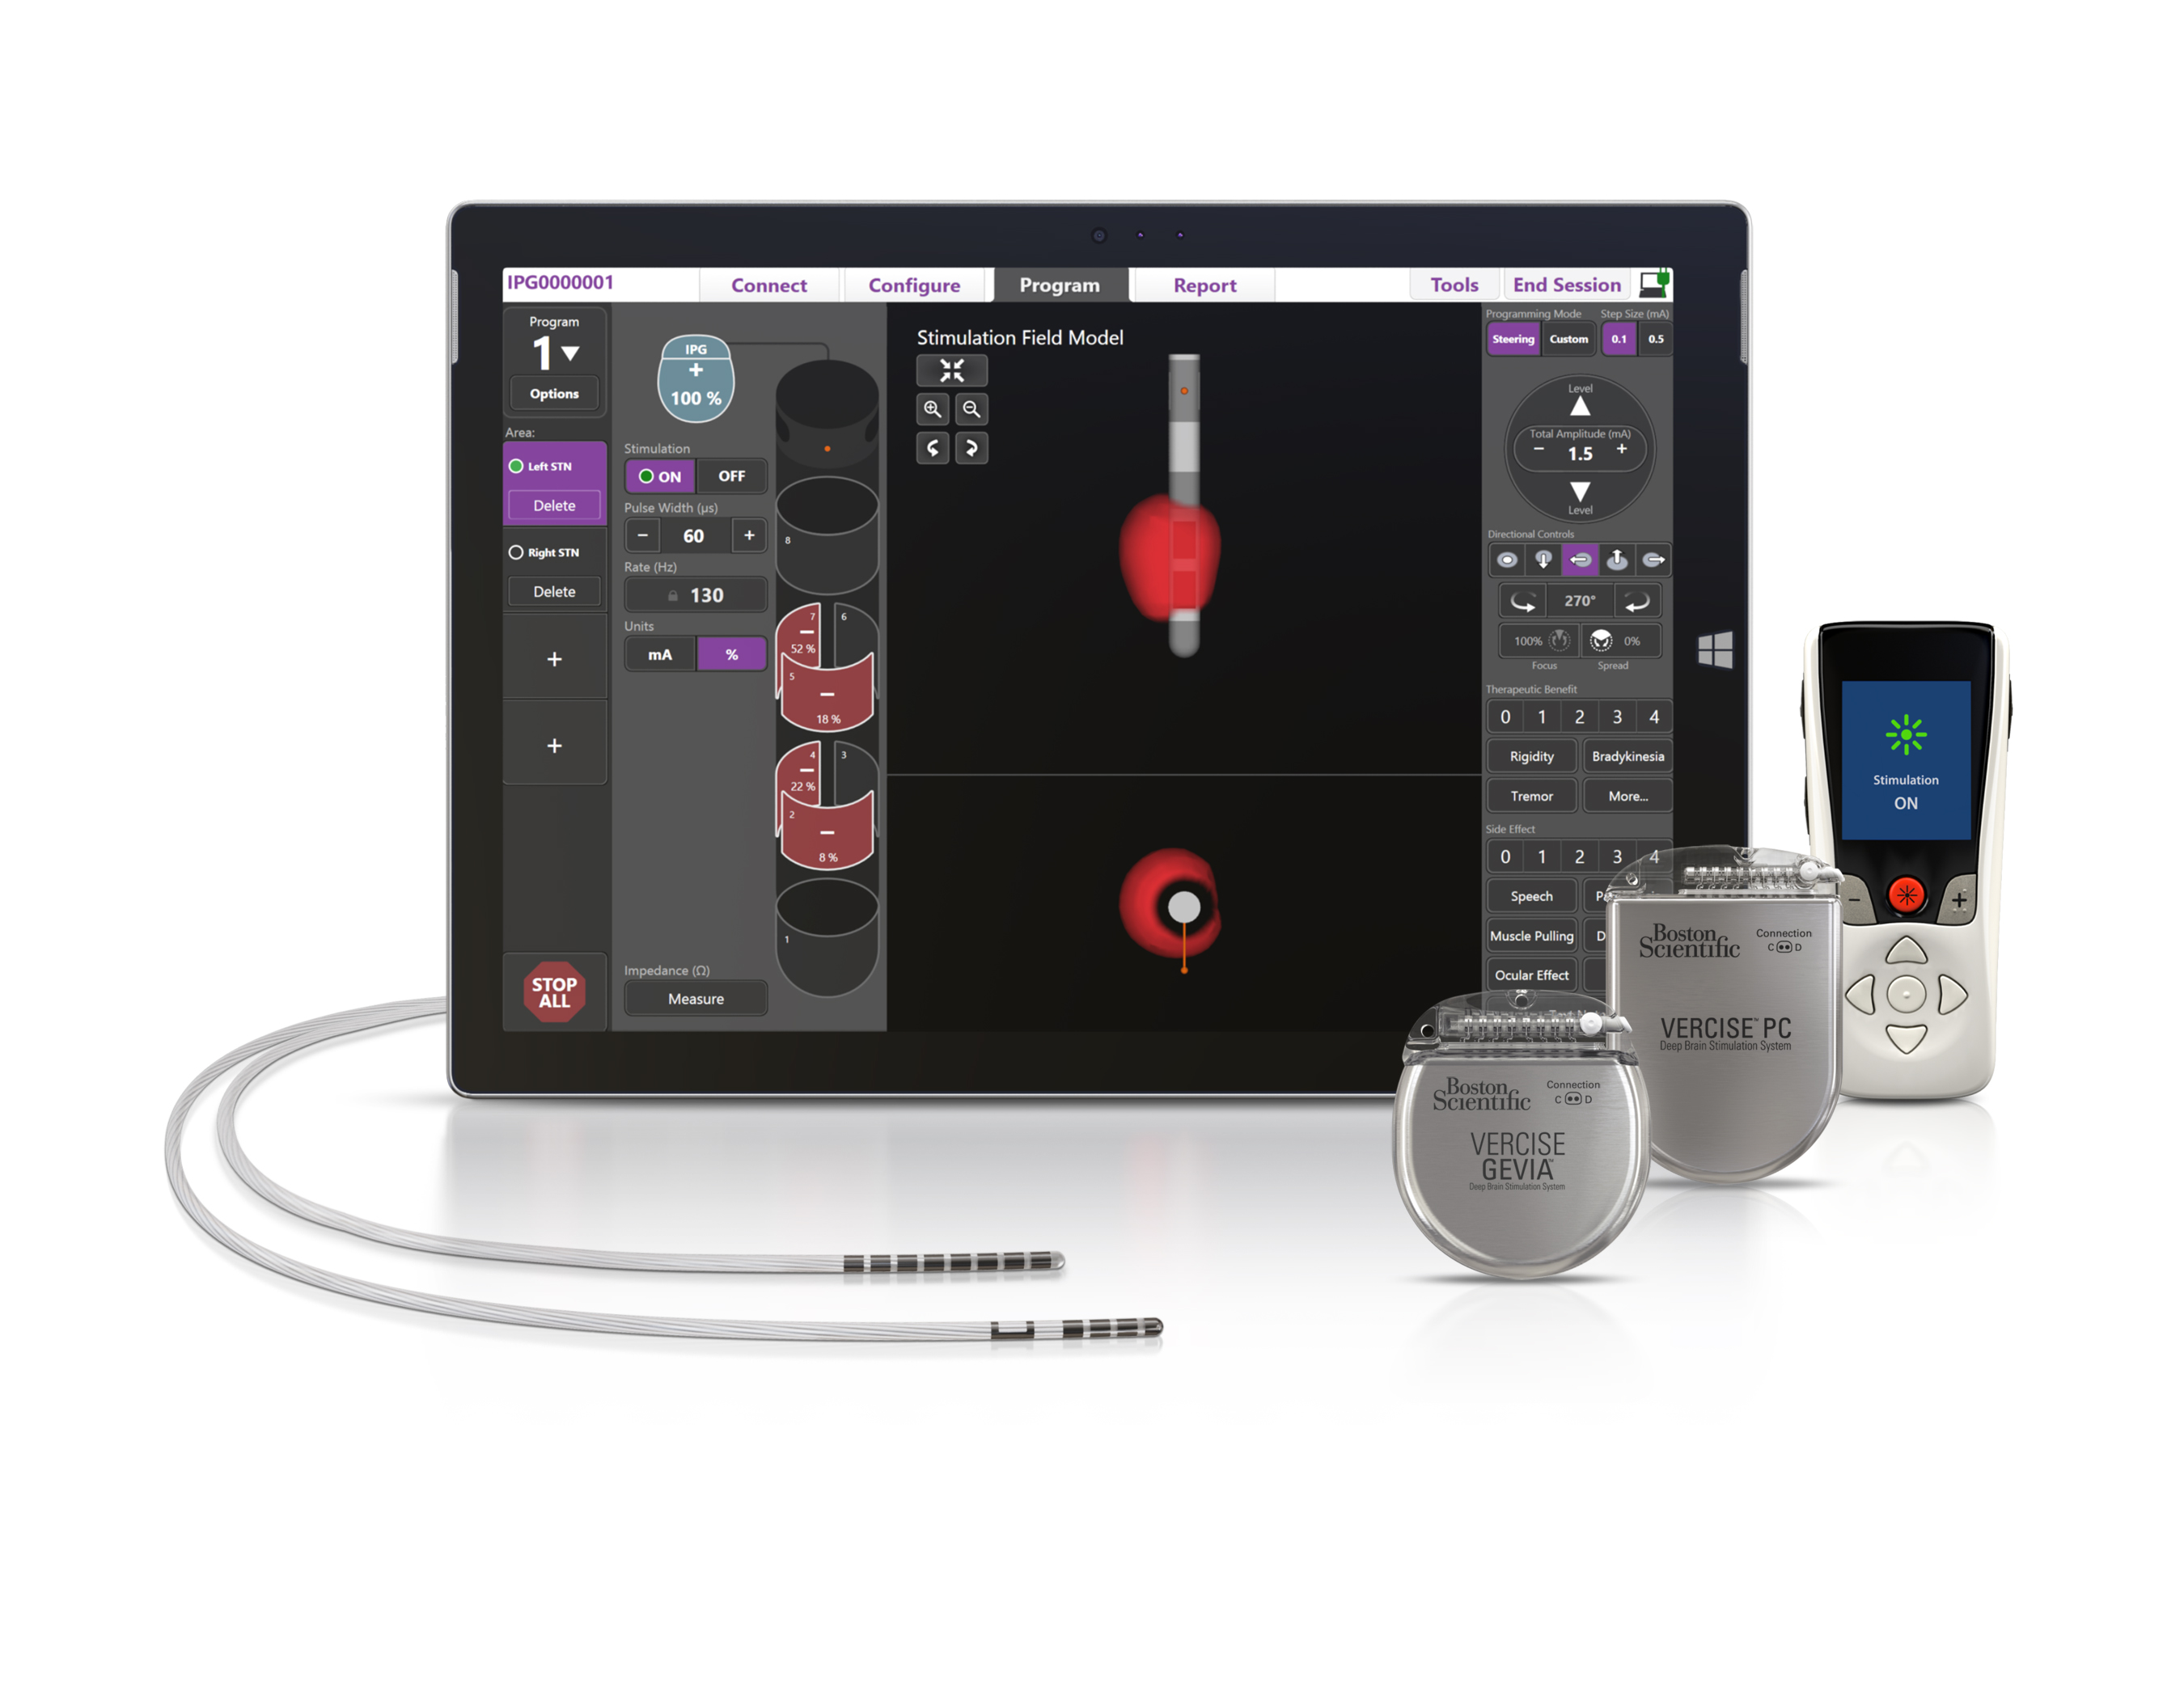

**PROBLEM**: the long time and low efficiency of the neurostimulation programs selection due to the increase in the number of adjustable parameters and the lack of an adequate history of  patients response on program settings.

**THE PROJECT OBJECTIVE**: to create a recommender system with using of a machine learning algorithms for selecting optimal neurostimulation parameters based on patient data (user-based) and already used programs (item-based).



# EDA: the Dataset Description

In [1]:
import io
import os
import math
import copy
import pickle
from collections import defaultdict
from itertools import zip_longest
from urllib.error import URLError
from urllib.request import urlopen
import requests
from urllib.parse import urlencode 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [106]:
results = pd.DataFrame(columns=['Model','RMSE','Precision@100', 'Recall@100'])

There is no available dataset for building a recommender system for neurostimulation. Russian clinics that adjust neurostimulators settings do not maintain digital databases of the patients' settings and feedbacks. Information about similar databases abroad could not be found either. Therefore, to achieve the goals of this project, a dataset was constructed based on:



*  real data of 3 patients with different types of dystonia and programming experience;
*  medical periodicals on the long-term outcomes of the dystonia patients with DBS ([Park et al., 2016](https://doi.org/10.1371/journal.pone.0146644));
*  technical characteristics of the neurostimulator Boston Scientific Vercise ([Vercise Programming Manual](https://www.bostonscientific.com/content/dam/Manuals/us/current-rev-en/92161115-01_RevB_Vercise_DBS_Programming_Manual_DFU_en-US_S.pdf).

In [107]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/XfulrNtzZ0eZCg' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url, sep=';',  decimal=',')
df.head()

,ProgramID,PatientID,ProgramDate,DoB,Sex,Diagnosis,BFMDRS_motor,Program_usage_time,RatingBefore,RatingAfter,RatingScore,Area1,Area2,Area3,Area4,Amplitude,Rate,PulseWidth
0,1,1,31.08.22,29.09.80,Female,G.dystonia,85,5,6.5,6.5,0.0,0.0,33.3,33.3,33.4,3.5,185,180
1,2,1,31.08.22,29.09.80,Female,G.dystonia,85,97,5.0,7.5,2.5,0.0,33.3,33.3,33.4,3.4,170,200
2,3,1,31.08.22,29.09.80,Female,G.dystonia,85,1,7.5,6.5,-1.0,100.0,0.0,0.0,0.0,2.2,185,180
3,4,1,31.08.22,29.09.80,Female,G.dystonia,85,2,7.5,7.0,-0.5,50.0,16.6,16.6,16.8,3.0,185,150
4,5,1,07.06.22,29.09.80,Female,G.dystonia,85,94,5.0,6.5,1.5,0.0,33.3,33.3,33.4,3.4,170,220


In [4]:
df['DoB'] = pd.to_datetime(df['DoB'], errors='coerce')
df['Age'] = (pd.to_datetime('today') - df['DoB']).astype('<m8[Y]')

df['Age'] = abs(df['Age']).astype(int)

del df['DoB']

df['RatingScore'] = df['RatingScore'].astype(float)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ProgramID           1121 non-null   int64  
 1   PatientID           1121 non-null   int64  
 2   ProgramDate         1121 non-null   object 
 3   Sex                 1121 non-null   object 
 4   Diagnosis           1121 non-null   object 
 5   BFMDRS_motor        1121 non-null   int64  
 6   Program_usage_time  1121 non-null   int64  
 7   RatingBefore        1121 non-null   float64
 8   RatingAfter         1121 non-null   float64
 9   RatingScore         1121 non-null   float64
 10  Area1               1121 non-null   float64
 11  Area2               1121 non-null   float64
 12  Area3               1121 non-null   float64
 13  Area4               1121 non-null   float64
 14  Amplitude           1121 non-null   float64
 15  Rate                1121 non-null   int64  
 16  PulseW

**The DARASET FEATURE DESCRIPTION**

1. ProgramID is a dataset key, a unique number for each program session. At the same time, technically the program can be repeated, but in combination with the patient info and the program date, it is unique. One user can have several programs (usually 4 programs are set during one one session). A large number of programs indicates the difficulty in achieving optimal results. This feature is the target, and we need to recomend it to the patient.

2. PatientID - a specific patient (user) to whom we will recommend an existing program.

3. ProgramDate - the date the program setting.

4. DoB - patient's date of birth from 8 to 60 years (recommended limits).
 
5. Sex - the patient's gender.
 
6. Diagnosis - diagnosis. Initially, we took only one diagnosis the dystonia, but when describing patients, we introduced subtypes that characterize of a greater extent the severity of the disease. This feature correlates with the BFMDRS_motor, as well as with the levels of Amplitude, Rate, PulseWidth settings. Distonia types in dataset:

   - G. generalized dystonia - 80%
   - S. segmental dystonia - 14%
   - M. multifocal dystonia - 6%.

7. BFMDRS_motor - assessment of the clinical manifestations of dystonia degree according to the Burke-Fahn-Mardsen dystonic movement scale. It ranges from 1 to 120, and correlates with the Diagnosis (G.dystonia - 100-60, S.dystonia - 60-50, M.dystonia -50-40).

8. Program_usage_time - during the program session, the patient receives a set of 4 programs that she/he need to test for several weeks. The stimulator records the time of using each program, which is to some extent an implicit assessment of its effectiveness.
 
9. RatingBefore - a subjective assessment of the patient's condition before using the program from 1 to 10. In theory, the indicator correlates with BFMDRS_motor.

10. RatingAfter - subjective assessment of the patient's condition after using the program from 1 to 10.

11. RatingScore - the difference between the RatingBefore and the RatingAfter (a negative value indicates the patient's condition deterioration).

12 - 15. 'Area1', 'Area2', 'Area3', 'Area4' – the zones of the stimulation distribution (100% in total).

16. Amplitude - amplitude (range 0.1-20).

17. Rate - rate (range 2-255).

18. PulseWidth - pulse width (range 10-450).

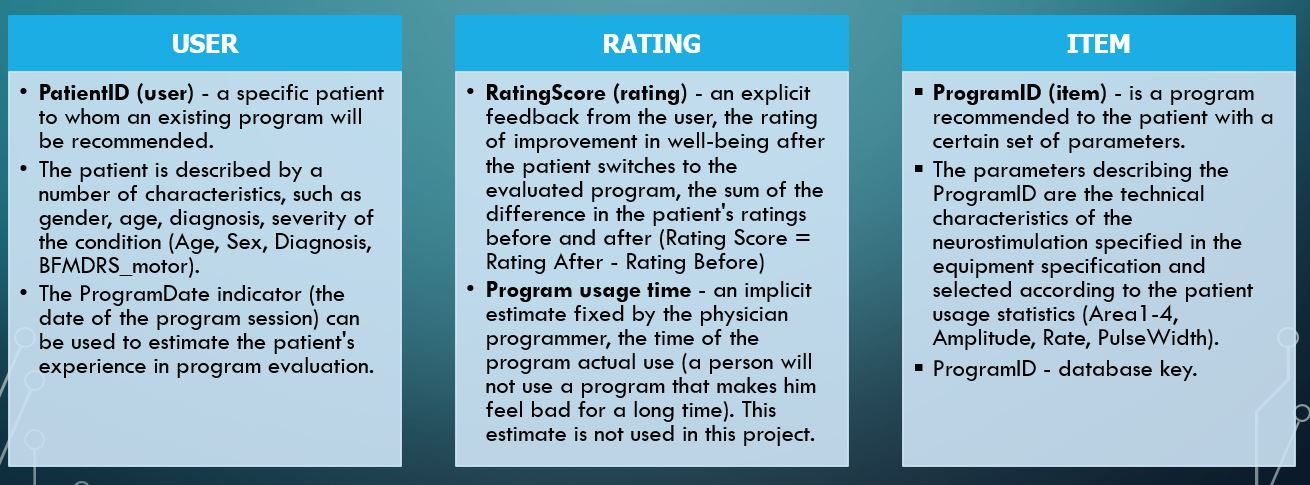

In [6]:
df.describe()

,ProgramID,PatientID,BFMDRS_motor,Program_usage_time,RatingBefore,RatingAfter,RatingScore,Area1,Area2,Area3,Area4,Amplitude,Rate,PulseWidth,Age
count,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000
mean,561.000000,106.610169,73.094558,27.454059,5.048171,5.950937,0.902765,26.496789,25.234255,24.804193,23.464764,2.818198,124.148082,118.693131,29.090098
std,323.749131,62.047553,13.279212,18.140914,1.375454,1.332392,1.292113,29.543074,18.954901,19.042205,29.521615,0.840083,40.119369,45.406993,11.912025
min,1.000000,1.000000,40.000000,1.000000,1.500000,2.500000,-2.500000,0.000000,0.000000,0.000000,0.000000,1.000000,50.000000,50.000000,7.000000
25%,281.000000,62.000000,65.000000,15.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,90.000000,90.000000,20.000000
50%,561.000000,98.000000,75.000000,25.000000,5.000000,6.000000,0.500000,25.000000,33.300000,33.300000,16.800000,3.000000,120.000000,110.000000,27.000000
75%,841.000000,147.000000,85.000000,35.000000,6.000000,7.000000,1.500000,50.000000,33.300000,33.400000,33.400000,3.500000,160.000000,150.000000,40.000000
max,1121.000000,225.000000,95.000000,97.000000,8.500000,9.500000,5.500000,100.000000,100.000000,100.000000,100.000000,5.500000,200.000000,800.000000,50.000000


The project uses a dataset specially designed based on real data. From the ML point of view, this dataset turned out to be relatively small (224 unique users, 1121 unique programs), which imposes certain restrictions. At the same time, it traces the patterns inherent in this particular problem.  A number of researchers believe that large neural networks with hundreds of parameters per training observation are able to generalize well from small noisy datasets ([Olson et al, 2018](https://dl.acm.org/doi/10.5555/3327144.3327279)). In addition, due to the small dataset size, the training time is significantly reduced, which allows to conduct a large number of experiments and select the optimal network settings. 

In [7]:
df.shape

(1121, 18)

In [8]:
df.columns

Index(['ProgramID', 'PatientID', 'ProgramDate', 'Sex', 'Diagnosis',
       'BFMDRS_motor', 'Program_usage_time', 'RatingBefore', 'RatingAfter',
       'RatingScore', 'Area1', 'Area2', 'Area3', 'Area4', 'Amplitude', 'Rate',
       'PulseWidth', 'Age'],
      dtype='object')

In [9]:
df.isna().sum()

ProgramID             0
PatientID             0
ProgramDate           0
Sex                   0
Diagnosis             0
BFMDRS_motor          0
Program_usage_time    0
RatingBefore          0
RatingAfter           0
RatingScore           0
Area1                 0
Area2                 0
Area3                 0
Area4                 0
Amplitude             0
Rate                  0
PulseWidth            0
Age                   0
dtype: int64

In [10]:
len(df)- len(df.drop_duplicates())

0

In [11]:
df.corr()

<ipython-input-11-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,ProgramID,PatientID,BFMDRS_motor,Program_usage_time,RatingBefore,RatingAfter,RatingScore,Area1,Area2,Area3,Area4,Amplitude,Rate,PulseWidth,Age
ProgramID,1.000000,0.979930,0.399800,0.032697,-0.011488,0.064537,0.078778,-0.034361,0.059972,0.075414,-0.052764,0.182859,0.087643,0.078487,-0.230619
PatientID,0.979930,1.000000,0.339131,0.047139,0.010081,0.072161,0.063680,-0.023814,0.059860,0.060431,-0.053583,0.179812,0.056989,0.069021,-0.180112
BFMDRS_motor,0.399800,0.339131,1.000000,-0.057609,-0.253907,-0.101396,0.165727,0.053305,0.095645,0.017940,-0.126326,0.656528,0.695838,0.505673,-0.450337
Program_usage_time,0.032697,0.047139,-0.057609,1.000000,-0.072193,0.493750,0.585992,-0.022759,0.007258,0.039716,-0.007502,0.061501,0.036925,0.073425,0.006525
RatingBefore,-0.011488,0.010081,-0.253907,-0.072193,1.000000,0.545002,-0.502509,-0.076274,0.036483,0.115714,-0.021733,-0.112067,-0.184033,-0.104281,0.140030
RatingAfter,0.064537,0.072161,-0.101396,0.493750,0.545002,1.000000,0.451019,-0.046838,0.078927,0.122665,-0.082927,0.027760,-0.042039,0.001854,0.044974
RatingScore,0.078778,0.063680,0.165727,0.585992,-0.502509,0.451019,1.000000,0.032895,0.042552,0.003312,-0.062376,0.147921,0.152553,0.112919,-0.102686
Area1,-0.034361,-0.023814,0.053305,-0.022759,-0.076274,-0.046838,0.032895,1.000000,-0.025924,-0.625409,-0.580677,0.076805,0.062419,0.027892,-0.059242
Area2,0.059972,0.059860,0.095645,0.007258,0.036483,0.078927,0.042552,-0.025924,1.000000,0.013216,-0.624650,0.085555,0.086231,0.037433,-0.032471
Area3,0.075414,0.060431,0.017940,0.039716,0.115714,0.122665,0.003312,-0.625409,0.013216,1.000000,-0.027647,-0.037376,-0.019933,-0.022065,0.011692


<ipython-input-12-f6b711afecad>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

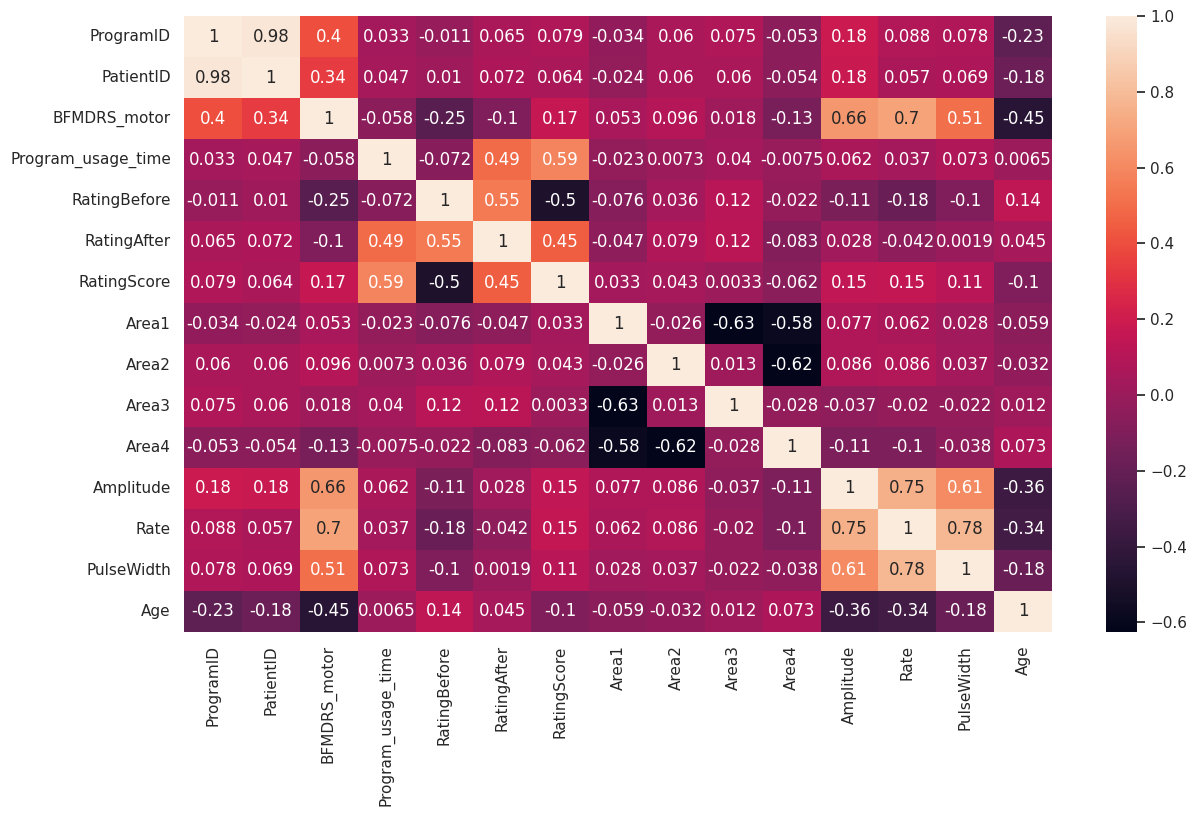

In [12]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(df.corr(), annot=True)


In [13]:
count_diagnosis = df.groupby('Diagnosis').count()[['PatientID']].sort_values(by='PatientID', ascending=False)
count_diagnosis.head()

,PatientID
Diagnosis,
G.dystonia,909
S.dystonia,160
M.dystonia,52


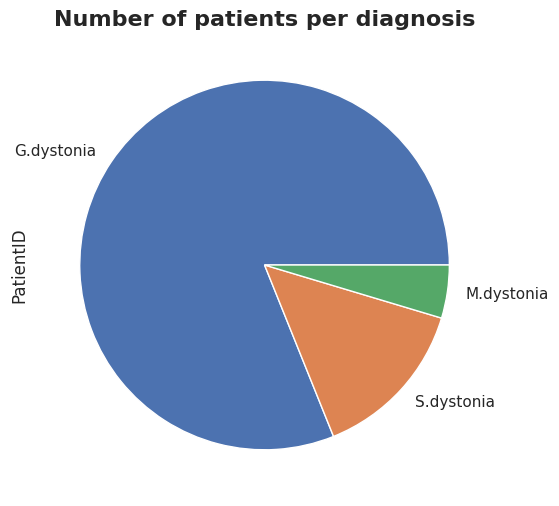

In [14]:
count_diagnosis.plot(kind ='pie',figsize=(10,6),legend = False, subplots = True)
plt.title('Number of patients per diagnosis', fontsize=16, fontdict={"weight": "bold"})
plt.show()

In [15]:
sd_diagnosis_rating = df[['Diagnosis','RatingScore']].explode('Diagnosis')
sd_diagnosis_rating.head()

,Diagnosis,RatingScore
0,G.dystonia,0.0
1,G.dystonia,2.5
2,G.dystonia,-1.0
3,G.dystonia,-0.5
4,G.dystonia,1.5


Text(0.5, 1.0, 'RatingScore boxplot')

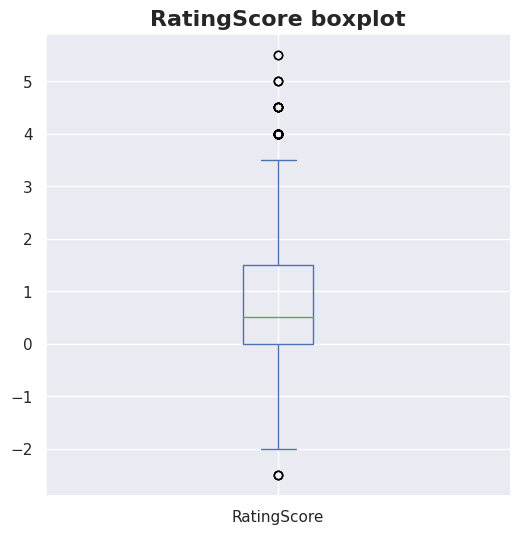

In [16]:
df.RatingScore.plot.box(figsize=(6, 6))
plt.title('RatingScore boxplot', fontsize=16, fontdict={"weight": "bold"})

<ipython-input-17-ff0cbb3e6c6d>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['RatingScore'], bins=50)


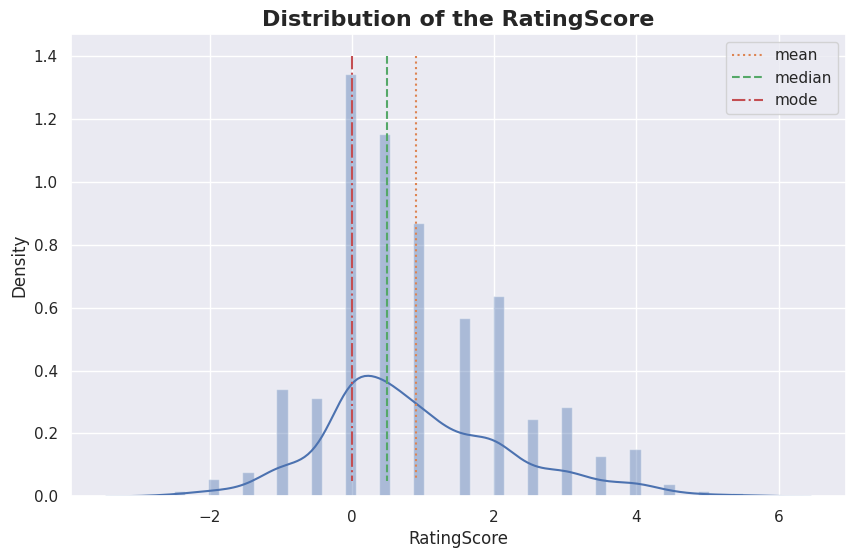

In [17]:
target_mean = round(df['RatingScore'].mean(), 2)
target_median = df['RatingScore'].median()
target_mode = df['RatingScore'].mode()

plt.figure(figsize = (10, 6))

sns.distplot(df['RatingScore'], bins=50)

y = np.linspace(1.4, 0.05, 10)
plt.plot([target_mean]*10, y, label='mean', linestyle=':', linewidth=1.5)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=1.5)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=1.5)

plt.title('Distribution of the RatingScore', fontsize=16, fontdict={"weight": "bold"})
plt.legend()
plt.show()

<ipython-input-18-028a4766ed1c>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['BFMDRS_motor'], bins=50)


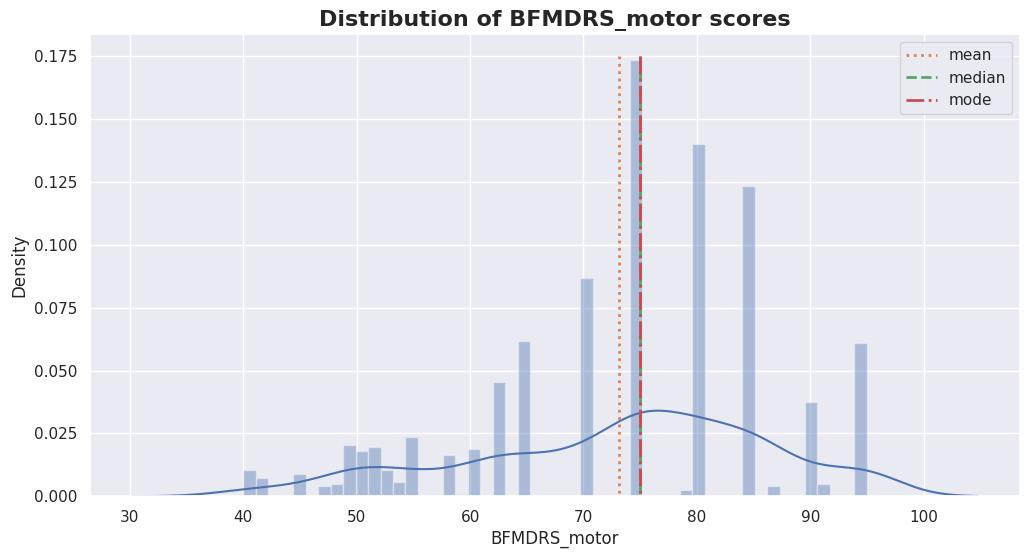

In [18]:
target_mean = round(df['BFMDRS_motor'].mean(), 2)
target_median = df['BFMDRS_motor'].median()
target_mode = df['BFMDRS_motor'].mode()

plt.figure(figsize = (12, 6))

sns.distplot(df['BFMDRS_motor'], bins=50)

y = np.linspace(0.175, 0.0005, 10)
plt.plot([target_mean]*10, y, label='mean', linestyle=':', linewidth=2)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=2)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=2)

plt.title('Distribution of BFMDRS_motor scores', fontsize=16, fontdict={"weight": "bold"})
plt.legend()
plt.show()

In [21]:
df.PatientID.value_counts()

225    12
215    12
224    12
223    12
222    12
       ..
202     1
203     1
204     1
205     1
195     1
Name: PatientID, Length: 224, dtype: int64

Text(0.5, 1.0, 'Density of the Program Sessions among Patients')

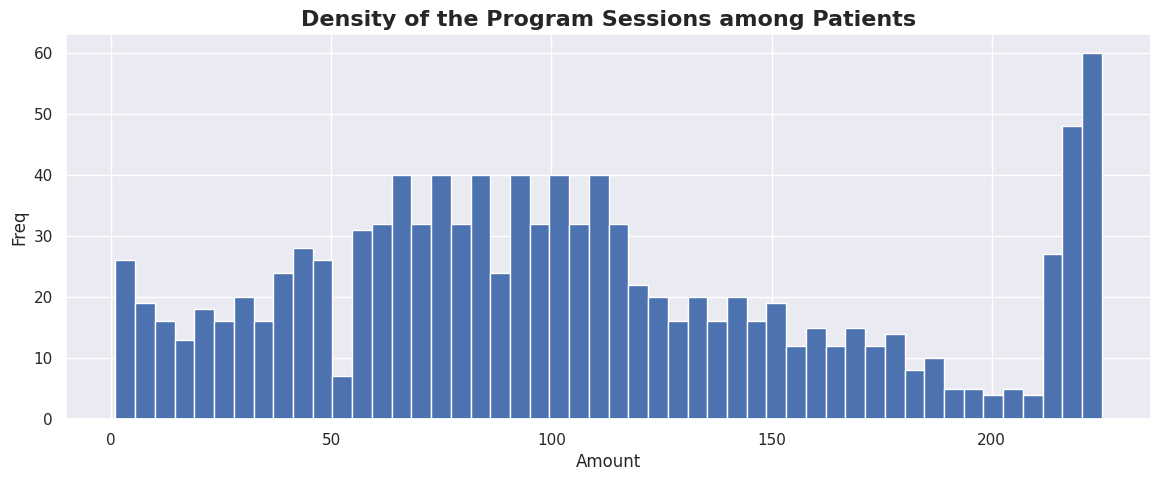

In [22]:
df['PatientID'].plot.hist(bins=50, figsize=(14, 5))
plt.xlabel('Amount')
plt.ylabel('Freq')
plt.title('Density of the Program Sessions among Patients', fontsize=16, fontdict={"weight": "bold"})

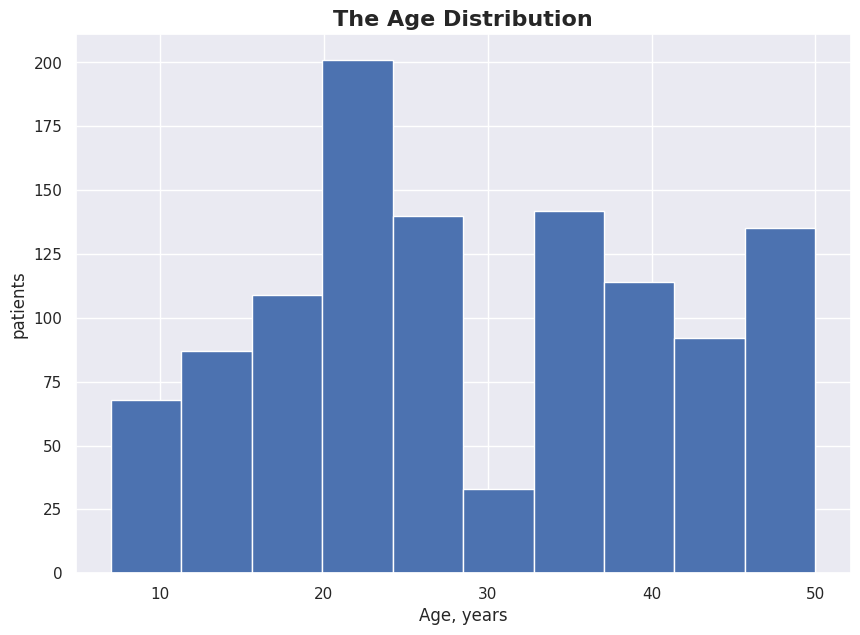

In [23]:
plt.figure(figsize=(10, 7))

plt.hist(df['Age'], bins=10)

plt.title('The Age Distribution',fontsize=16, fontdict={"weight": "bold"})
plt.xlabel('Age, years')
plt.ylabel('patients')

plt.show()

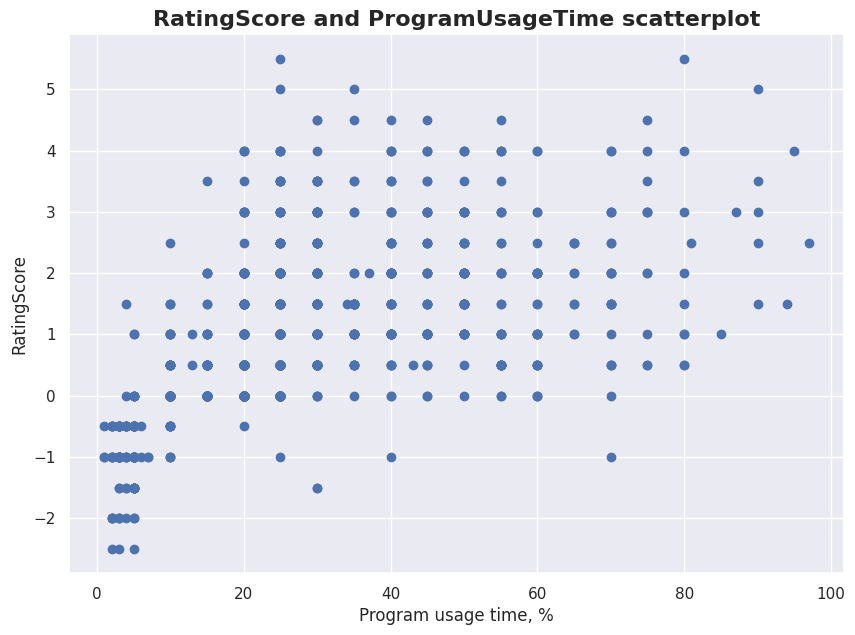

In [24]:
plt.figure(figsize=(10, 7))

plt.scatter(df['Program_usage_time'], df['RatingScore'])

plt.title('RatingScore and ProgramUsageTime scatterplot', fontsize=16, fontdict={"weight": "bold"})
plt.xlabel('Program usage time, %')
plt.ylabel('RatingScore')

plt.show()

Text(0.5, 1.0, "Demographics of the diagnosis' distribution")

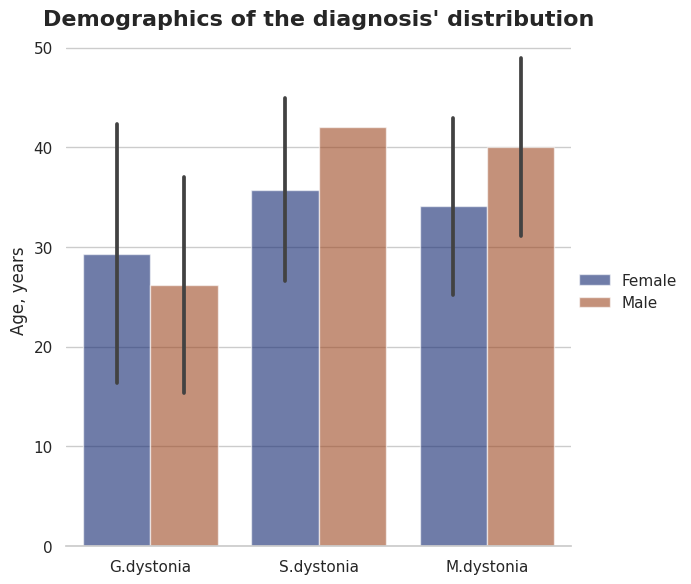

In [25]:
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=df, kind="bar",
    x='Diagnosis', y='Age', hue='Sex',
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Age, years")
g.legend.set_title("")

plt.title("Demographics of the diagnosis' distribution",
                  fontsize=16, fontdict={"weight": "bold"})

In [26]:
df['Rating_category'] = pd.cut(df['RatingScore'], [-2.5, 0, 3, np.inf], labels=[1,2,3])
diagnosis_rating = df[['RatingScore', 'Rating_category']]
diagnosis_rating.head(10)

## divided ratings into 3 levels:
## 1 - the program worsened the state (negative rating)
## 2 - the program has slightly improved the state (0-3)
## 3 - the program significantly improved the state (3+)

,RatingScore,Rating_category
0,0.0,1
1,2.5,2
2,-1.0,1
3,-0.5,1
4,1.5,2
5,-1.5,1
6,0.5,2
7,-1.0,1
8,2.0,2
9,3.0,2


Text(0.5, 1.0, 'Demographics of program adjustment outcomes')

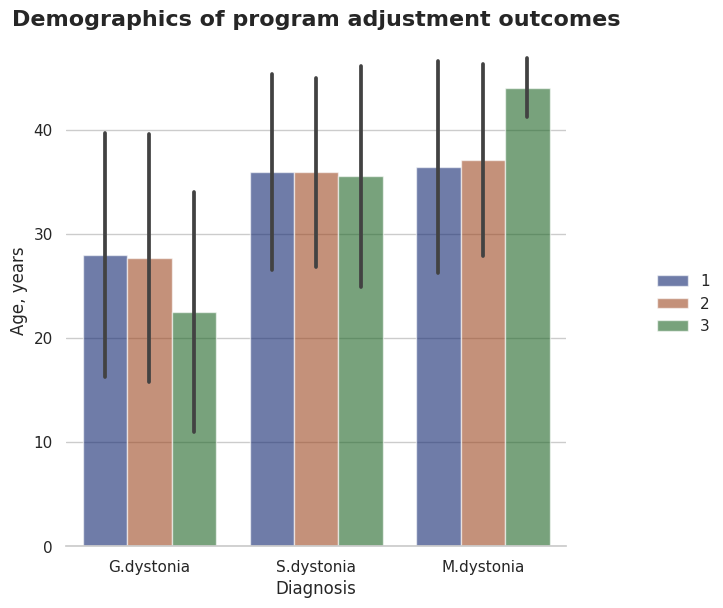

In [27]:
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=df, kind="bar",
    x='Diagnosis', y='Age', hue='Rating_category',
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Diagnosis", "Age, years")
g.legend.set_title("")
plt.title("Demographics of program adjustment outcomes",
                  fontsize=16, fontdict={"weight": "bold"})

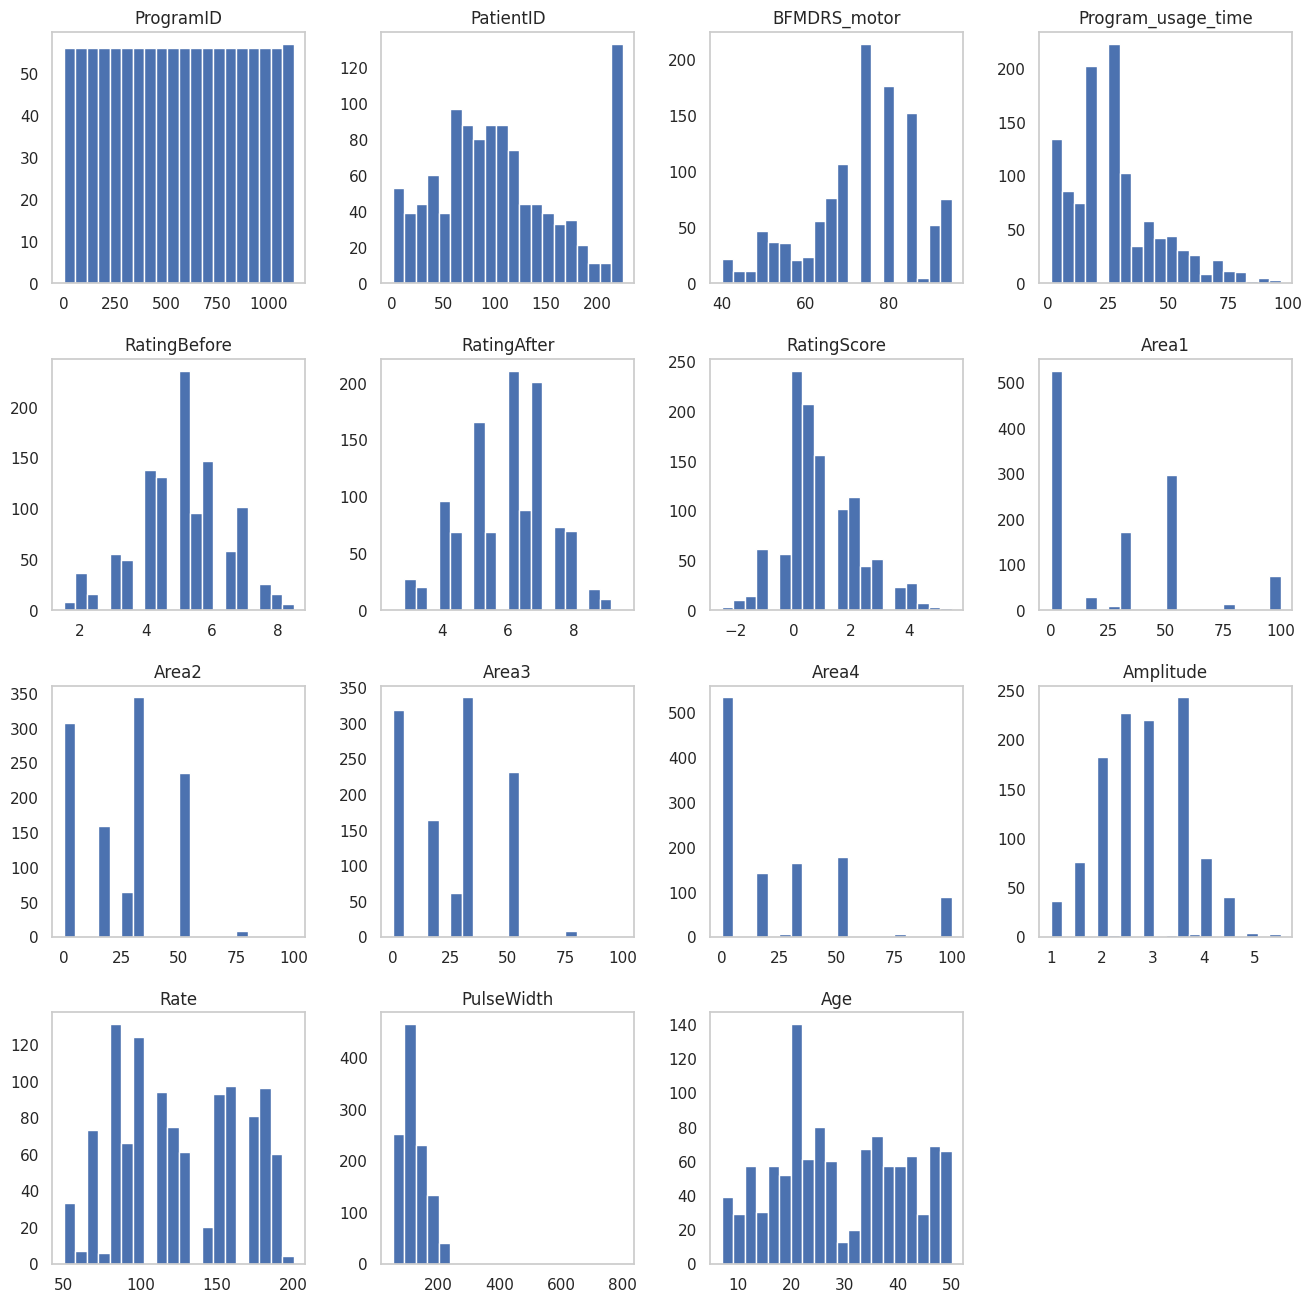

In [28]:
df.hist(figsize=(16, 16), bins=20, grid=False);

# Feature engineering: DBSCAN (items clustering)

In [108]:
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 

In [109]:
df.columns

Index(['ProgramID', 'PatientID', 'ProgramDate', 'DoB', 'Sex', 'Diagnosis',
       'BFMDRS_motor', 'Program_usage_time', 'RatingBefore', 'RatingAfter',
       'RatingScore', 'Area1', 'Area2', 'Area3', 'Area4', 'Amplitude', 'Rate',
       'PulseWidth'],
      dtype='object')

In [110]:
selectedColumns = df[['ProgramID','Area1', 'Area2', 'Area3', 'Area4', 'Amplitude', 'Rate',
       'PulseWidth']]

X = (selectedColumns)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ProgramID   1121 non-null   int64  
 1   Area1       1121 non-null   float64
 2   Area2       1121 non-null   float64
 3   Area3       1121 non-null   float64
 4   Area4       1121 non-null   float64
 5   Amplitude   1121 non-null   float64
 6   Rate        1121 non-null   int64  
 7   PulseWidth  1121 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 70.2 KB


In [111]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)
X_normalized = normalize(X_scaled) 
X_normalized = pd.DataFrame(X_normalized) 

In [112]:
pcaX = PCA(n_components = 2)
X_principal = pcaX.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['C1', 'C2'] 
X_principal.head() 

,C1,C2
0,-0.532191,0.485103
1,-0.503902,0.475452
2,-0.396106,-0.444588
3,-0.537963,-0.118218
4,-0.528328,0.461167


In [113]:
clusters = DBSCAN(eps = 0.0375, min_samples = 3).fit(X_principal)
clusters.labels_


array([ 0,  0, -1, ..., 31, 18, 10])

In [114]:
set(clusters.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89}

In [115]:
from collections import Counter
Counter(clusters.labels_)

Counter({0: 5,
         -1: 221,
         1: 7,
         2: 22,
         34: 15,
         3: 30,
         4: 4,
         5: 40,
         6: 4,
         7: 6,
         22: 7,
         8: 7,
         9: 3,
         10: 7,
         11: 6,
         12: 63,
         13: 40,
         14: 3,
         15: 7,
         16: 14,
         24: 3,
         17: 35,
         18: 11,
         19: 10,
         27: 17,
         20: 10,
         21: 21,
         29: 3,
         23: 13,
         25: 13,
         46: 5,
         26: 9,
         28: 24,
         30: 4,
         42: 25,
         73: 7,
         75: 5,
         31: 6,
         32: 16,
         33: 9,
         35: 5,
         36: 4,
         37: 3,
         38: 16,
         39: 7,
         40: 4,
         41: 4,
         57: 9,
         43: 6,
         44: 6,
         45: 15,
         56: 3,
         47: 12,
         48: 27,
         49: 5,
         50: 3,
         51: 4,
         52: 6,
         53: 5,
         54: 8,
         59: 14,
         

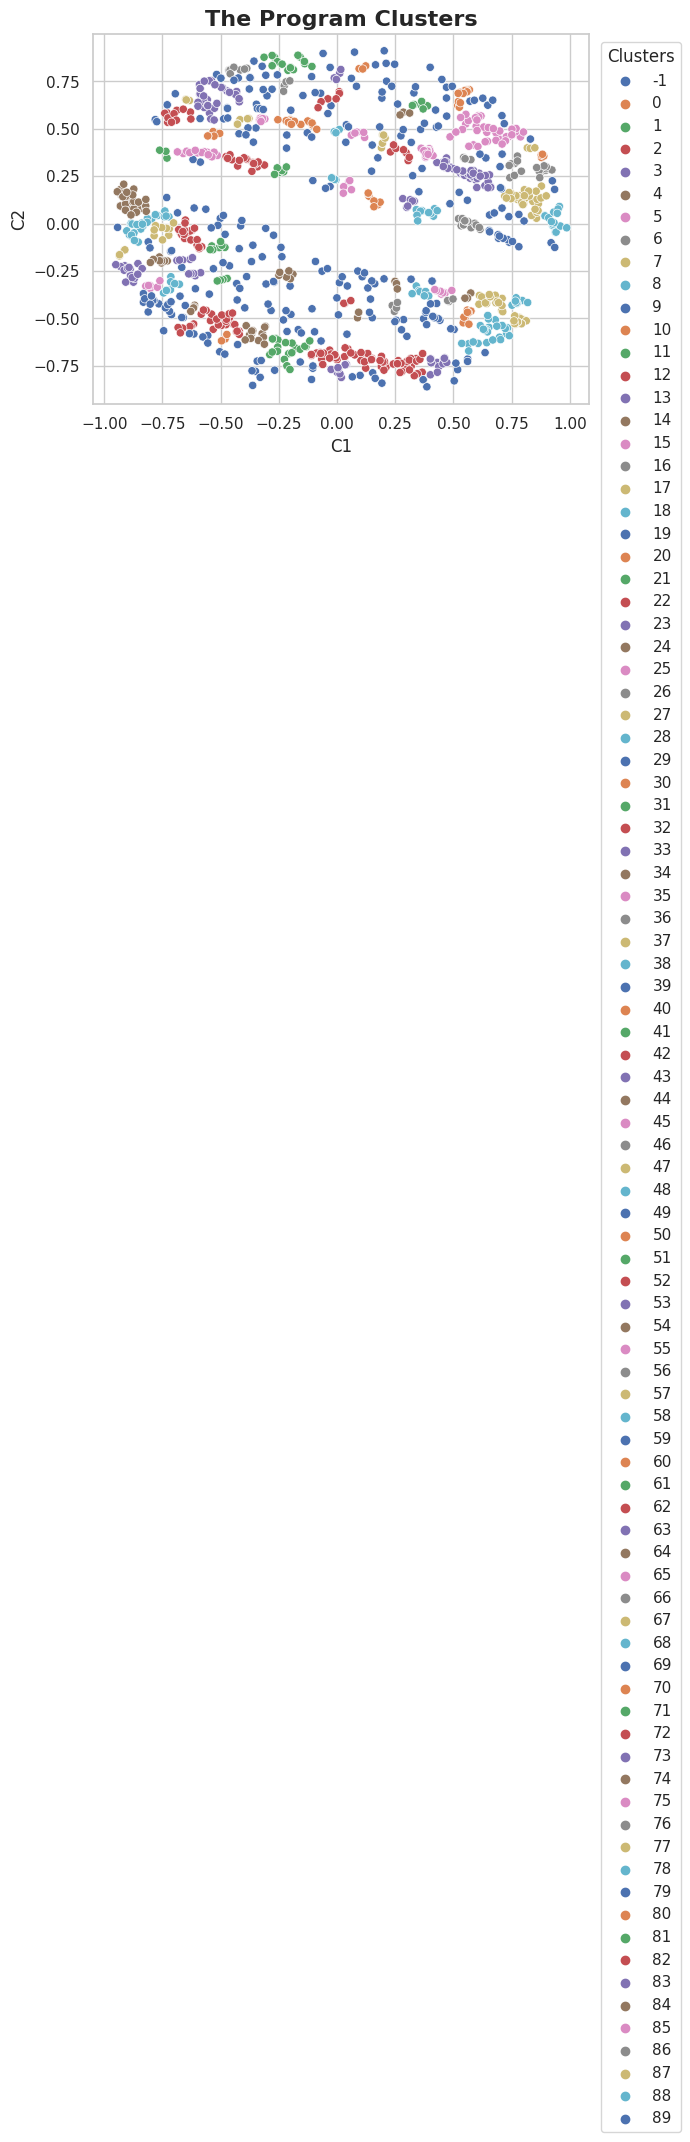

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

p = sns.scatterplot(data = X_principal, x = X_principal['C1'], y = X_principal['C2'], hue = clusters.labels_, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.20, 1.), title = 'Clusters')
plt.title('The Program Clusters', fontsize=16, fontdict={"weight": "bold"})
plt.show()

In [117]:
from sklearn import preprocessing

df['ProgramID'] = clusters.labels_
df.head()

,ProgramID,PatientID,ProgramDate,DoB,Sex,Diagnosis,BFMDRS_motor,Program_usage_time,RatingBefore,RatingAfter,RatingScore,Area1,Area2,Area3,Area4,Amplitude,Rate,PulseWidth
0,0,1,31.08.22,29.09.80,Female,G.dystonia,85,5,6.5,6.5,0.0,0.0,33.3,33.3,33.4,3.5,185,180
1,0,1,31.08.22,29.09.80,Female,G.dystonia,85,97,5.0,7.5,2.5,0.0,33.3,33.3,33.4,3.4,170,200
2,-1,1,31.08.22,29.09.80,Female,G.dystonia,85,1,7.5,6.5,-1.0,100.0,0.0,0.0,0.0,2.2,185,180
3,1,1,31.08.22,29.09.80,Female,G.dystonia,85,2,7.5,7.0,-0.5,50.0,16.6,16.6,16.8,3.0,185,150
4,0,1,07.06.22,29.09.80,Female,G.dystonia,85,94,5.0,6.5,1.5,0.0,33.3,33.3,33.4,3.4,170,220


# Recommender system based on collaborative filtering - ALS Surprise algorithm

In [118]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
from surprise import KNNWithMeans, KNNBasic, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import split

In [120]:
dataset = pd.DataFrame({
    'uid': df.PatientID,
    'iid': df.ProgramID,
    'rating': df.RatingScore
})

In [121]:
dataset.head()

,uid,iid,rating
0,1,0,0.0
1,1,0,2.5
2,1,-1,-1.0
3,1,1,-0.5
4,1,0,1.5


In [122]:
df.RatingScore.min()

-2.5

In [123]:
df.RatingScore.max()

5.5

In [124]:
reader = Reader(rating_scale=(-0.0, 8.5))
data = Dataset.load_from_df(dataset, reader)

In [125]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

In [126]:
dataset['uid'].nunique(), dataset['iid'].nunique()

(224, 91)

In [127]:
kSplit = split.KFold(n_splits=10, shuffle=True)

In [128]:
bsl_options = {"method": "als", "n_epochs": 5, "reg_u": 25, "reg_i": 10}
algo = BaselineOnly(bsl_options=bsl_options)

algo.fit(trainset)

test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

test_pred[:3]

algo.predict(uid=1, iid=1)

Estimating biases using als...
RMSE: 1.2116


Prediction(uid=1, iid=1, r_ui=None, est=1.2115654223557344, details={'was_impossible': False})

In [129]:
cross_validate(algo,data,measures=['RMSE', 'MAE'],cv=5, verbose=False, n_jobs=-1)

{'test_rmse': array([1.37433426, 1.26174533, 1.15291019, 1.26810546, 1.28532686]),
 'test_mae': array([1.07193766, 0.98905281, 0.90718285, 0.98199791, 0.99754629]),
 'fit_time': (0.0006759166717529297,
  0.0007672309875488281,
  0.0007607936859130859,
  0.0006978511810302734,
  0.000766754150390625),
 'test_time': (0.0007979869842529297,
  0.0008533000946044922,
  0.0007851123809814453,
  0.0008037090301513672,
  0.0011723041534423828)}

In [130]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [131]:
pkl_filename = 'surprise_model.pkl'
with open(pkl_filename, 'wb') as file: 
    pickle.dump(algo, file) 

In [132]:
predictions = algo.test(testset)

precisions, recalls = precision_recall_at_k(predictions, k=100, threshold=0.1)

print(f'precision@K: {sum(prec for prec in precisions.values()) / len(precisions)}, recall@k: {sum(rec for rec in recalls.values()) / len(recalls)}')

results.loc[len(results)] = ['Model SurpriseALS', rmse, sum(prec for prec in precisions.values()) / len(precisions), sum(rec for rec in recalls.values()) / len(recalls)]

precision@K: 0.6326034063260341, recall@k: 0.7664233576642335


In [133]:
def recommendation_Surprise(uid, model, dataset, thresh=0.5, amount=5):
    all_titles = list(dataset['iid'].values)
    users_seen_titles = dataset[dataset['uid'] == uid]['iid']
    titles = np.array(list(set(all_titles) - set(users_seen_titles)))

    np.random.shuffle(titles)
    
    rec_list = []
    for title in titles:
        review_prediction = model.predict(uid=uid, iid=title)
        rating = review_prediction.est

        if rating >= thresh:
            rec_list.append((title, round(rating, 2)))
            
            if len(rec_list) >= amount:
                return rec_list

In [134]:
recommendation_Surprise(1, algo, dataset)

[(25, 0.73), (4, 0.81), (5, 0.87), (33, 0.6), (36, 0.78)]

# Recommender system based on neural collaborative filtering (NCF) - Keras 


In [135]:
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [136]:
import random as rn 
 
np.random.seed(0) 
rn.seed(0) 
tf.random.set_seed(0) 

In [137]:
g = df.groupby('PatientID')['RatingScore'].count()
top_users = g.sort_values(ascending=False)[:15]

g = df.groupby('ProgramID')['RatingScore'].count()
top_items = g.sort_values(ascending=False)[:15]

top_r = df.join(top_users, rsuffix='_r', how='inner', on='PatientID')
top_r = top_r.join(top_items, rsuffix='_r', how='inner', on='ProgramID')

pd.crosstab(top_r.PatientID, top_r.ProgramID, top_r.RatingScore, aggfunc=np.sum)

ProgramID,-1,3,5,12,13,17,21,38,42,63
PatientID,,,,,,,,,,
57,0.0,NaN,NaN,NaN,NaN,0.5,NaN,2.5,NaN,NaN
78,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,-1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,NaN,NaN,NaN,-1.0,NaN,NaN,1.5,NaN,-0.5,0.0
216,0.0,NaN,NaN,3.0,NaN,NaN,0.0,NaN,0.5,NaN
217,3.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
218,0.5,NaN,NaN,4.0,NaN,NaN,2.0,NaN,0.0,NaN
219,3.5,NaN,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [138]:
user_enc = LabelEncoder()

df['user'] = user_enc.fit_transform(df['PatientID'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['item'] = item_enc.fit_transform(df['ProgramID'].values)
n_items = df['item'].nunique()

df['rating'] = df['RatingScore'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_items, min_rating, max_rating

(224, 91, -2.5, 5.5)

In [139]:
X = df[['user', 'item']].values
y = df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1008, 2), (113, 2), (1008,), (113,))

In [140]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [141]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Embedding
from keras.optimizers import Adam, SGD, Nadam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda
from tensorflow.keras.initializers import glorot_uniform
import keras.backend as K

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderNet(n_users, n_items, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    item = Input(shape=(1,))
    i = EmbeddingLayer(n_items, n_factors)(item)
    
    x = Concatenate()([u, i])
    x = Dropout(0.5)(x)

    x = Dense(128, kernel_initializer='glorot_uniform')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('tanh')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, item], outputs=x)
    opt = keras.optimizers.experimental.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam'
    )

    model.compile(loss='mean_squared_error', optimizer=opt, metrics= ([keras.metrics.RootMeanSquaredError()]))
    
    return model

In [142]:
model = RecommenderNet(n_users, n_items, n_factors, min_rating, max_rating)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        11200       ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 50)        4550        ['input_4[0][0]']                
                                                                                            

In [143]:
pkl_filename = 'keras_model.pkl'
with open(pkl_filename, 'wb') as file: 
    pickle.dump(model, file) 

In [144]:
history = model.fit(x=X_train_array, y=y_train, batch_size=16, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
63/63 [==============================] - 2s 6ms/step - loss: 2.2958 - root_mean_squared_error: 1.5151 - val_loss: 1.7683 - val_root_mean_squared_error: 1.3297
Epoch 2/20
63/63 [==============================] - 0s 3ms/step - loss: 1.9398 - root_mean_squared_error: 1.3927 - val_loss: 1.7817 - val_root_mean_squared_error: 1.3347
Epoch 3/20
63/63 [==============================] - 0s 3ms/step - loss: 1.8764 - root_mean_squared_error: 1.3698 - val_loss: 1.7540 - val_root_mean_squared_error: 1.3243
Epoch 4/20
63/63 [==============================] - 0s 2ms/step - loss: 1.8274 - root_mean_squared_error: 1.3517 - val_loss: 1.7658 - val_root_mean_squared_error: 1.3288
Epoch 5/20
63/63 [==============================] - 0s 2ms/step - loss: 1.7404 - root_mean_squared_error: 1.3192 - val_loss: 1.7458 - val_root_mean_squared_error: 1.3212
Epoch 6/20
63/63 [==============================] - 0s 2ms/step - loss: 1.7068 - root_mean_squared_error: 1.3064 - val_loss: 1.7683 - val_root_mean_sq

In [145]:
rmse_k = (history.history['root_mean_squared_error'][-1])
print(f'RMSE: {rmse_k}') 

RMSE: 1.1245529651641846


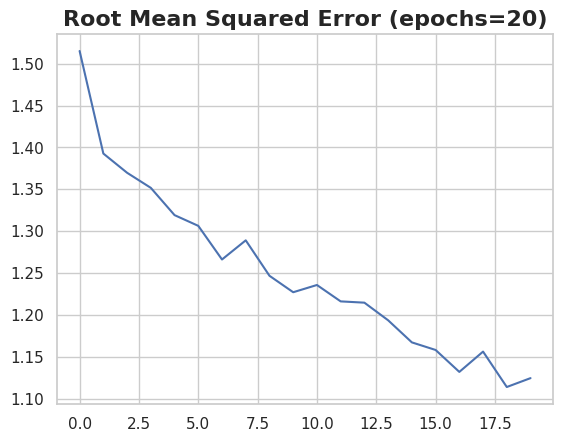

In [146]:
plt.plot(history.history['root_mean_squared_error'])
plt.title('Root Mean Squared Error (epochs=20)', fontsize=16, fontdict={"weight": "bold"})
plt.show()

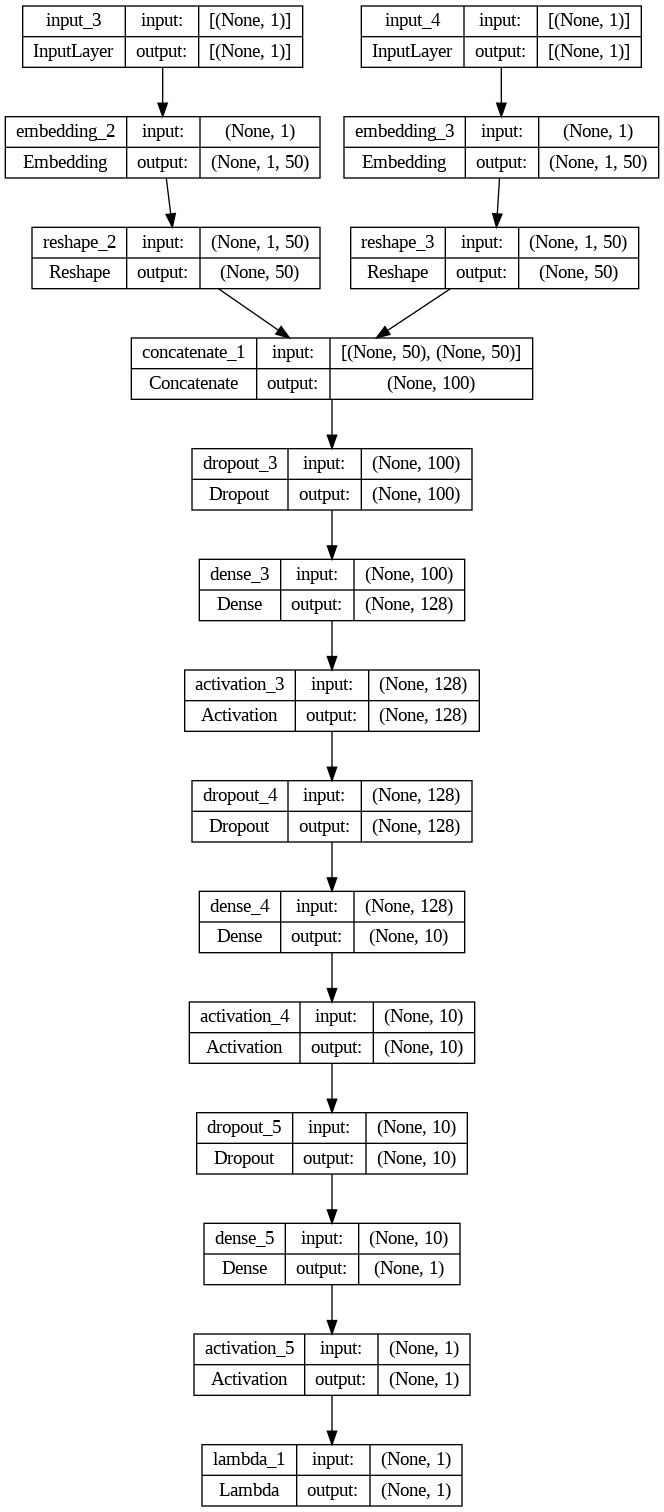

In [147]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [148]:
g_truth = []
g_truth.extend(y_test.tolist())
g_truth = np.asarray(g_truth).ravel()
g_truth

array([ 3. , -1. ,  1.5,  0. ,  3. ,  0. ,  4. ,  0. , -1. ,  2. ,  1.5,
        1. ,  1. ,  1.5,  2. ,  4. ,  0.5,  2. ,  0. ,  1. ,  0. , -1. ,
        0.5,  0.5,  1. ,  0. ,  2. , -1. ,  3. ,  0.5,  2.5,  0. , -0.5,
        0. ,  3.5,  1.5,  1. ,  3.5,  2. ,  0. ,  1.5,  0. ,  0. ,  0.5,
        0.5, -0.5,  0.5,  1. ,  3.5,  1.5,  2. ,  0.5,  1. ,  0. ,  0.5,
        0. ,  3. ,  0. , -1. ,  2. ,  1.5, -0.5,  1. ,  1.5,  1.5,  1.5,
       -1. ,  1.5,  2.5,  3. ,  1. ,  3. ,  0. ,  0. ,  1.5, -2. ,  0.5,
        1.5,  2. ,  1. , -1. ,  3. ,  1.5,  1.5,  0.5,  4. , -1. ,  1.5,
        0. ,  1. ,  2. ,  0.5,  3. , -2.5,  0. ,  0.5,  1. , -1. , -1. ,
        1.5,  0.5,  0.5, -2. ,  1. ,  0.5,  0. ,  1. ,  0. ,  0.5,  0. ,
        3. ,  1.5,  1. ])

In [149]:
prediction_k = model.predict(X_test_array, batch_size=64)

2/2 [==============================] - 0s 4ms/step


In [150]:
prediction = prediction_k.tolist()
prediction = np.asarray(prediction).ravel()
prediction

array([ 0.35199571,  1.13916183,  0.27459788,  0.44667459,  0.77544498,
        0.35274816,  0.47518826,  1.07293773,  0.79768252,  0.78973508,
        0.66363287,  0.65527773,  1.43648505,  0.66094303,  0.98191166,
        2.1243906 ,  1.30719757,  1.10837221,  0.85610485,  0.44934678,
        1.38691139,  0.31136322,  0.57677317,  1.37175846,  0.5404377 ,
        0.71173501,  0.52247024,  0.5404377 ,  0.73212647,  0.54687834,
        0.48817158,  0.17757463,  0.43870926,  0.47635746,  1.49777222,
        0.63827586,  0.22924042,  2.38803816,  1.69940424,  1.65956211,
        0.43595433,  0.77557826, -0.10953569,  0.70579362,  2.14809322,
        0.34729385,  0.88286734,  0.64413786,  1.0284245 ,  1.34724545,
        0.51914454,  0.3641758 ,  1.41997242,  1.21467376,  1.33296275,
        0.39093876,  0.8672452 ,  1.34888506,  1.10560989,  0.58150935,
        0.50119352,  0.55264449,  1.95944643,  0.51259637,  0.44765067,
        0.8576436 ,  0.80389714,  2.50629091,  0.76655793,  1.05

In [151]:
threshold = 0.1
binary_predictions = (prediction >= threshold).astype(int)

k = 100
sorted_indices = np.argsort(prediction)[::-1]
top_k_indices = sorted_indices[:k]

top_k_prediction = binary_predictions[top_k_indices]
top_k_g_truth = (g_truth[top_k_indices] >= threshold).astype(int)


num_correct = np.sum(top_k_prediction == top_k_g_truth)
precision1_at_k = num_correct / k


num_relevant = np.sum(g_truth >= threshold)
recall1_at_k = num_correct / num_relevant if num_relevant > 0 else 0

results.loc[len(results)] = ['Model Keras', rmse_k, precision1_at_k, recall1_at_k]

print("Precision@k:", precision1_at_k)
print("Recall@k:", recall1_at_k)

Precision@k: 0.69
Recall@k: 0.9078947368421053


In [152]:
dataset = pd.DataFrame({
'uid': df.PatientID,
'iid': df.ProgramID,
'rating': df.RatingScore
})
def recommendation_Keras(uid, model, dataset, thresh=0.5, amount=5):
  all_titles = list(dataset['iid'].values)
  users_seen_titles = dataset[dataset['uid'] == uid]['iid']
  titles = np.array(list(set(all_titles) - set(users_seen_titles)))

  np.random.shuffle(titles)

  rec_list = []
  for title in titles:
    X_user_array = np.array([uid])
    X_item_array = np.array([title])
    review_prediction = model.predict([X_user_array, X_item_array])
    rating = review_prediction[0][0]

    if rating >= thresh:
      rec_list.append((title, round(rating, 2)))

      if len(rec_list) >= amount:
        return rec_list

    return rec_list

In [153]:
recommendation_Keras(1, model, dataset)

1/1 [==============================] - 0s 20ms/step


[(5, 1.23)]

# Recommender system based on neural collaborative filtering (NCF) - PyTorch



In [154]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)
    

In [155]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

In [156]:
def create_dataset(df, top=None):
    if top is not None:
        df.groupby('PatientID')['RatingScore'].count()
    
    unique_users = df.PatientID.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = df.PatientID.map(user_to_index)
    
    unique_items = df.ProgramID.unique()
    item_to_index = {old: new for new, old in enumerate(unique_items)}
    new_items = df.ProgramID.map(item_to_index)
    
    n_users = unique_users.shape[0]
    n_items = unique_items.shape[0]
    
    X = pd.DataFrame({'PatientID': new_users, 'ProgramID': new_items})
    y = df['RatingScore'].astype(np.float32)
    return (n_users, n_items), (X, y), (user_to_index, item_to_index)

In [157]:
(n, i), (X, y), _ = create_dataset(df)
print(f'Embeddings: {n} users, {i} items')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')
     

Embeddings: 224 users, 91 items
Dataset shape: (1121, 2)
Target shape: (1121,)


In [158]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [159]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [160]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[222,  90],
        [ 12,  17],
        [ 92,   1],
        [ 39,   1]])
tensor([[ 1.0000],
        [ 1.5000],
        [-0.5000],
        [-1.0000]])


In [161]:
class EmbeddingNet(nn.Module):
    
    def __init__(self, n_users, n_items,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.i = nn.Embedding(n_items, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, items, minmax=None):
        features = torch.cat([self.u(users), self.i(items)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        
        return out
    
    def _init(self):
        
        def init(i):
            if type(i) == nn.Linear:
                torch.nn.init.xavier_uniform_(i.weight)
                i.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.i.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')
     

In [162]:
EmbeddingNet(n, i, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(224, 150)
  (i): Embedding(91, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [163]:
EmbeddingNet(n, i, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])


EmbeddingNet(
  (u): Embedding(224, 150)
  (i): Embedding(91, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [164]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
     

In [165]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [166]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
     
    return scheduler

In [167]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

In [168]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [169]:
minmax = float(df.RatingScore.min()), float(df.RatingScore.max())
minmax

(-2.5, 5.5)

In [170]:
net = EmbeddingNet(
    n_users=n, n_items=i, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [171]:
lr = 1e-3
wd = 1e-5
bs = 32
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))


In [172]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False

        running_loss = 0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            #print(x_batch[:,0])
          
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss improvement on epoch: 1
[001/100] train: 1.7407 - val: 1.5214
loss improvement on epoch: 2
[002/100] train: 1.6139 - val: 1.4337
[003/100] train: 1.5321 - val: 1.4349
[004/100] train: 1.2853 - val: 1.4409
[005/100] train: 1.3211 - val: 1.4948
[006/100] train: 1.1279 - val: 1.4368
[007/100] train: 1.1548 - val: 1.4922
[008/100] train: 0.9911 - val: 1.5430
[009/100] train: 1.0610 - val: 1.6363
[010/100] train: 0.9038 - val: 1.6970
[011/100] train: 0.9802 - val: 1.5774
[012/100] train: 0.7978 - val: 1.6998
early stopping after epoch 012


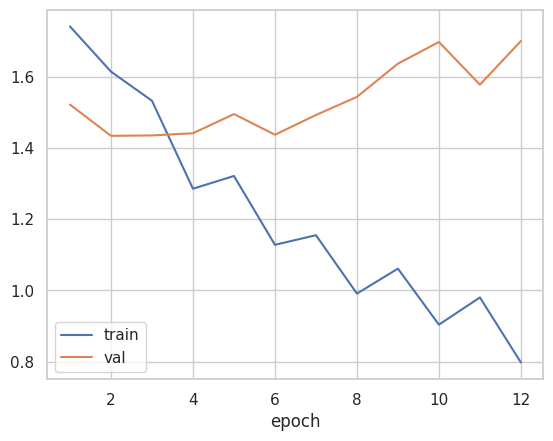

In [173]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

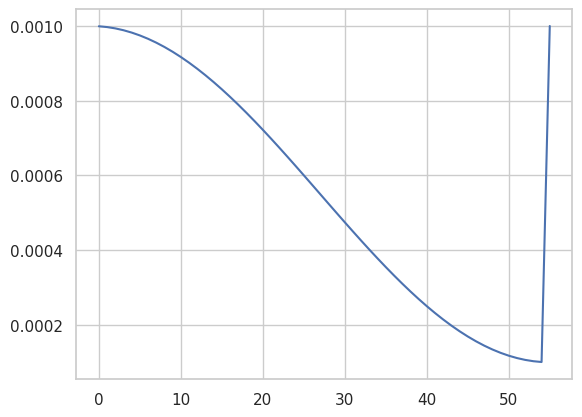

In [174]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [175]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [176]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [177]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
#rmse_t = {final_loss:.4f}
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 1.2064


In [178]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

In [179]:
groud_truth

array([ 1. ,  1.5, -0.5, -1. , -1. ,  1.5,  1.5,  1. ,  1.5,  2.5,  2. ,
       -2. ,  2. ,  0. ,  0. ,  1. , -1. ,  4. ,  0.5,  1. , -1. ,  1.5,
        0. ,  0.5,  3. ,  2. ,  2.5,  2.5, -2.5,  0. ,  2. ,  0.5,  0.5,
       -1. ,  0. ,  2.5,  0.5,  0.5,  0.5,  2. ,  0.5,  1. ,  2. ,  0. ,
        1. ,  0.5, -0.5,  0. ,  2.5,  0.5,  1. ,  0.5,  0. ,  2. ,  0. ,
        0. , -1. ,  1. ,  0. ,  1. ,  2. ,  2. ,  2. ,  2. , -1. ,  0.5,
       -1. ,  0. ,  0. , -1. ,  0.5,  0. , -1. ,  0. ,  0.5,  0. ,  1. ,
        0. ,  0.5,  1.5,  1. ,  1.5,  0.5,  1. , -1.5,  0.5,  2.5,  0.5,
        0.5,  1.5,  0. ,  0. ,  0.5,  0. ,  0. ,  2. ,  3.5,  0. ,  1.5,
        1. ,  1. ,  1.5,  1.5,  4. ,  0.5, -1. ,  1. ,  2. ,  1. ,  0.5,
        0. ,  2. ,  2. ,  3.5,  2. , -0.5,  2. ,  1.5,  0.5,  2. ,  0. ,
        0.5,  4. ,  0. ,  0.5,  0.5,  1.5, -0.5, -1. , -0.5,  0.5,  0.5,
        2. ,  1.5,  1.5,  1. ,  2. ,  2. ,  2. ,  0. ,  0. ,  2. ,  3.5,
        1. ,  0.5,  3. ,  2. ,  2. ,  0. ,  0. ,  3

In [180]:
predictions

array([1.08339787, 1.10337543, 0.54799676, 0.28299093, 0.63421893,
       0.92128038, 0.79249811, 0.59913731, 1.14263821, 0.80499244,
       0.73481345, 0.74301386, 1.35661602, 1.10126352, 0.7341907 ,
       1.03366804, 1.02799892, 0.84125662, 0.86958122, 0.82390285,
       0.9387126 , 1.30632496, 0.74654317, 0.78359413, 0.82144308,
       0.82885146, 0.60886359, 0.91349506, 0.73740911, 0.45393634,
       1.31667995, 0.97123575, 0.64999771, 0.76490712, 0.73796296,
       1.1558485 , 1.1038022 , 0.97034907, 0.72169161, 1.25323391,
       0.40982723, 1.01106596, 0.68342161, 1.10916138, 0.84557033,
       0.85901499, 1.29344749, 1.22746134, 1.14616585, 1.10751152,
       0.62400603, 0.75410891, 1.083992  , 0.7234621 , 0.62402558,
       0.66824102, 0.91585779, 0.86070776, 0.69525337, 1.17665434,
       0.94825006, 0.73716545, 0.70582151, 1.19411659, 0.88660955,
       0.8383131 , 0.77606297, 0.8447175 , 0.99653769, 0.91088462,
       0.7317903 , 0.78732538, 1.0230484 , 1.08671808, 0.73183

In [181]:
threshold = 0.1
binary_predictions = (predictions >= threshold).astype(int)

k = 100
sorted_indices = np.argsort(predictions)[::-1]
top_k_indices = sorted_indices[:k]

top_k_predictions = binary_predictions[top_k_indices]
top_k_ground_truth = (groud_truth[top_k_indices] >= threshold).astype(int)


num_correct = np.sum(top_k_predictions == top_k_ground_truth)
precision_at_k = num_correct / k


num_relevant = np.sum(groud_truth >= threshold)
recall_at_k = num_correct / num_relevant if num_relevant > 0 else 0

results.loc[len(results)] = ['Model PyTorch', final_loss, precision_at_k, recall_at_k]

print("Precision@k:", precision_at_k)
print("Recall@k:", recall_at_k)

Precision@k: 0.71
Recall@k: 0.45806451612903226


# Results

In [182]:
results

,Model,RMSE,Precision@100,Recall@100
0,Model SurpriseALS,1.211635,0.632603,0.766423
1,Model Keras,1.124553,0.690000,0.907895
2,Model PyTorch,1.206361,0.710000,0.458065


**Further development and improvement**

**Data**
1. Automation of data collection. As part of the project, a manually assembled dataset was used, in the future it makes sense to use information from programmers' automatic reports.
2. The visual data (MRI images) can be used as an additional feature. As a characteristic of the patient, MRI images of the brain with the location of the electrodes can be used. 
3. Instead of a general state rating, it makes sense to collect ratings for individual body areas, for example, use the segmented BFMDRS scale: arms, legs, torso, eyes, mouth, speech/swallowing ([Burke et al., 1982](https://doi.org/10.1212/wnl.32.12.1335)). Thus, it will be possible to select settings for a specific patient condition.

**Feature engineering**
4. Inclusion of implicit estimates in the analysis, namely the actual time of using a particular program (Program_usage_time). Available in programmer automatic reports, but requires special preproceeng.
5. The patients' categorization by the different types of characteristics. For instanc, the number of program sessions will provide weights for the experience in assessment.